In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf # import this function from this submodule
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors
import scipy.signal as ss
import pylab 
from statsmodels.tsa.stattools import acf

apple=yf.download('AAPL', start='1999-01-01', end='2024-12-31')
print(apple)

# The daily price 
apple_Pt=apple[['Close']].squeeze() # we squeeze to have a Pandas Series 
apple_Pt.index = pd.to_datetime(apple_Pt.index)

# The daily log price
pt_day=np.log(apple_Pt)



/var/folders/bl/x60glkc16f32tjg5b39jnkr40000gn/T/ipykernel_5216/3512177928.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  apple=yf.download('AAPL', start='1999-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open      Volume
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL
Date                                                                  
1999-01-04    0.309283    0.316780    0.299911    0.315843   952884800
1999-01-05    0.324747    0.329433    0.311157    0.314437  1410113600
1999-01-06    0.313032    0.330839    0.307408    0.330839  1348569600
1999-01-07    0.337400    0.337868    0.315843    0.316780  1429019200
1999-01-08    0.337400    0.351458    0.329901    0.349115   678832000
...                ...         ...         ...         ...         ...
2024-12-23  254.120667  254.498945  252.308854  253.622918    40858800
2024-12-24  257.037476  257.047410  254.140559  254.339671    23234700
2024-12-26  257.853790  258.928945  256.470064  257.027541    27237100
2024-12-27  254.439224  257.535238  251.920617  256.669129    42355300
2024-12-30  251.064499  252.358649  249.621030  251.094363    35557500

[6540

In [4]:
# Let's compute the monthly and annually LOG PRICES
pt_month= pt_day.resample('ME').last()
pt_month.name='pt_month'

pt_annual=pt_day.resample('YE').last()
pt_annual.name='pt_annual'

# And now the daily, monthly and annually LOG RETURNS
rt_day=pt_day.diff().dropna()
rt_day.name='rt_day'

rt_month=pt_month.diff().dropna()
rt_month.name='rt_month'

rt_annual=pt_annual.diff().dropna()
rt_annual.name='rt_annual'

print('Daily Log returns\n', rt_day,
      '\n\nMonthly Log returns\n', rt_month, 
      '\n\nAnnual Log returns\n', rt_annual)


# The length
print('\n\nThere are', len(apple_Pt), 'days,', len(rt_month)+1, 'months and', len(rt_annual)+1, 'years in the sample')
# I added 1 for the months and the years because it is the the log return, so the first data of the dataframe is not taken into account.

# Let's also compute the weekly log return for the next question
pt_week=pt_day.resample('W').last() # the weekly log price
rt_week=pt_week.diff().dropna()     # the weekly log return



Daily Log returns
 Date
1999-01-05    0.048789
1999-01-06   -0.036742
1999-01-07    0.074963
1999-01-08    0.000000
1999-01-11    0.019256
                ...   
2024-12-23    0.003060
2024-12-24    0.011413
2024-12-26    0.003171
2024-12-27   -0.013331
2024-12-30   -0.013352
Name: rt_day, Length: 6539, dtype: float64 

Monthly Log returns
 Date
1999-02-28   -0.168159
1999-03-31    0.031806
1999-04-30    0.246858
1999-05-31   -0.043032
1999-06-30    0.049802
                ...   
2024-08-31    0.031841
2024-09-30    0.017316
2024-10-31   -0.030902
2024-11-30    0.050414
2024-12-31    0.060771
Freq: ME, Name: rt_month, Length: 311, dtype: float64 

Annual Log returns
 Date
2000-12-31   -1.240078
2001-12-31    0.386803
2002-12-31   -0.424130
2003-12-31    0.399632
2004-12-31    1.103126
2005-12-31    0.803171
2006-12-31    0.165630
2007-12-31    0.847904
2008-12-31   -0.841911
2009-12-31    0.903817
2010-12-31    0.425712
2011-12-31    0.227597
2012-12-31    0.281917
2013-12-31    0.077

In [5]:
# Table of summary statistics of these three series of returns
### Statistics Table ###
print("\n======================= Statistics Tables =============")

def summary_statistics(returns):
    stats = {
        'Mean': round(returns.mean() * 100,5),
        'St.Deviation': round(returns.std() * 100,5),
        'Diameter.C.I.Mean': round(1.96 * np.sqrt(np.var(returns) / len(returns)) * 100,5),
        'Skewness': round(returns.skew(),5),
        'Kurtosis': round(returns.kurtosis()+3,5),  
        'Excess Kurtosis': round(returns.kurtosis(), 5),  
        'Min': round(returns.min() * 100,5),
        'Quant.5%': round(returns.quantile(0.05) * 100,5),
        'Quant.25%': round(returns.quantile(0.25) * 100,5),
        'Median.50%': round(returns.median() * 100,5),
        'Quant.75%': round(returns.quantile(0.75) * 100,5),
        'Quant.95%': round(returns.quantile(0.95) * 100,5),
        'Max': round(returns.max() * 100,5),
        'Jarque.Bera.stat': round(jarque_bera(returns)[0],5),
        'Jarque.Bera.pvalue': round(jarque_bera(returns)[1],5),
        'Lilliefors.stat': round(lilliefors(returns)[0],5),
        'Lilliefors.pvalue': round(lilliefors(returns)[1],5),
        'N.obs': round(len(returns),1),
    }
    return stats

stats_table = pd.DataFrame({
    'Daily': summary_statistics(rt_day),
    'Weekly': summary_statistics(rt_week),
    'Monthly': summary_statistics(rt_month),
    'Annual': summary_statistics(rt_annual)
})

print(stats_table)



======================= Statistics Tables =============
                           Daily       Weekly     Monthly     Annual
Mean                1.024500e-01      0.48763     2.15457   23.14381
St.Deviation        2.582460e+00      5.36447    11.73092   52.49359
Diameter.C.I.Mean   6.259000e-02      0.28543     1.30169   20.16174
Skewness           -3.605940e+00     -1.93552    -1.75357   -1.05719
Kurtosis            1.052041e+02     27.12213    13.72532    4.78694
Excess Kurtosis     1.022041e+02     24.12213    10.72532    1.78694
Min                -7.312480e+01    -70.64099   -86.14156 -124.00780
Quant.5%           -3.760780e+00     -7.43035   -15.00957  -75.83547
Quant.25%          -1.014060e+00     -2.18060    -3.58490    7.76047
Median.50%          1.001400e-01      0.69195     3.18411   29.74952
Quant.75%           1.312340e+00      3.36631     9.30907   42.57121
Quant.95%           3.893660e+00      8.08220    18.21900   89.26347
Max                 1.336524e+01     23.62067 

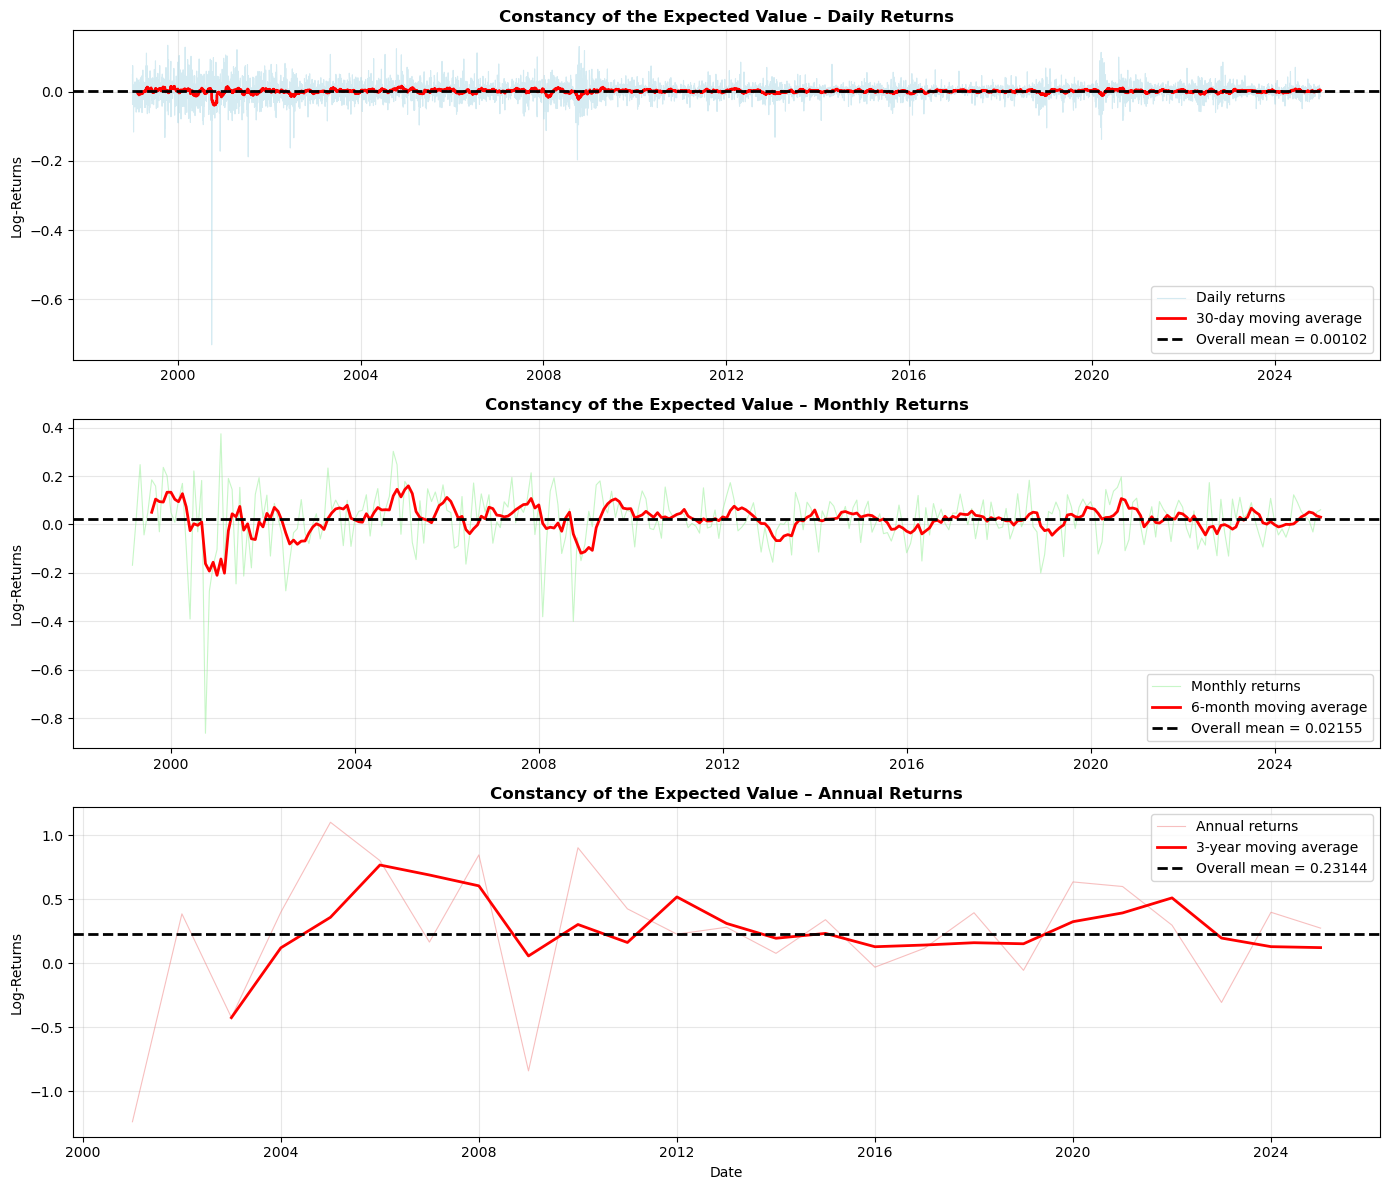

We examine the moving average of the daily, monthly and annually returns compared to the overall mean. As the moving average fluctuates around the overall mean without any sustained trend, this indicates that the expected value of the returns remains stable over time.


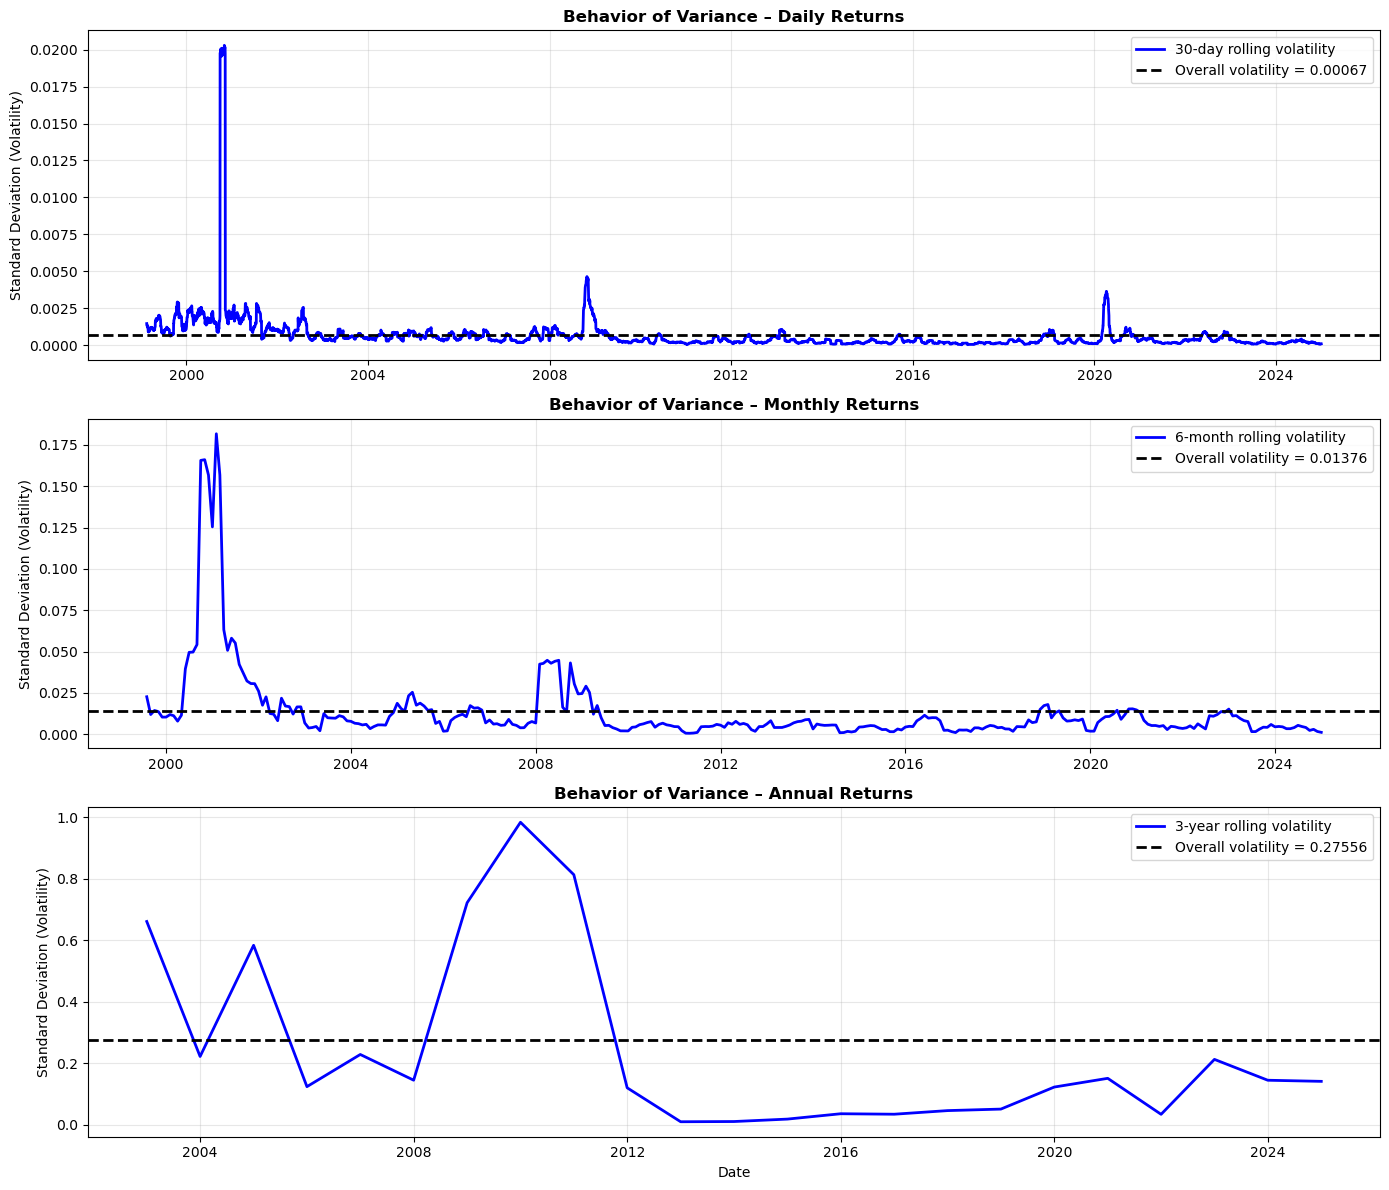

We examine the rolling variance of the daily, monthly and annually returns compared to the overall variance. In normal periods, the rolling variance fluctuates around the overall level, indicating that the variance is approximately stationary. However, during periods of financial crises (2001, 2008 and 2020), variance (and so volatility) can spike temporarily, breaking this stationarity. We exclude these periods in our analysis.

=> Apple’s datas are in adequation with this stylized fact


In [25]:
# FACT 1: Returns are stationary 

# Mean fluctuation over time
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1.1 Daily Returns
axes[0].plot(rt_day, alpha=0.5, linewidth=0.8, label='Daily returns', color='lightblue')
axes[0].plot(rt_day.rolling(window=30).mean(), color='red', linewidth=2, label='30-day moving average')
axes[0].axhline(y=rt_day.mean(), color='black', linestyle='--', linewidth=2, label=f'Overall mean = {round(rt_day.mean(),5)}')
axes[0].set_title('Constancy of the Expected Value – Daily Returns', fontweight='bold')
axes[0].set_ylabel('Log-Returns')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 1.2 Monthly Returns
axes[1].plot(rt_month, alpha=0.5, linewidth=0.8, label='Monthly returns', color='lightgreen')
axes[1].plot(rt_month.rolling(window=6).mean(), color='red', linewidth=2, label='6-month moving average')
axes[1].axhline(y=rt_month.mean(), color='black', linestyle='--', linewidth=2, label=f'Overall mean = {round(rt_month.mean(),5)}')
axes[1].set_title('Constancy of the Expected Value – Monthly Returns', fontweight='bold')
axes[1].set_ylabel('Log-Returns')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 1.3 Annual Returns
axes[2].plot(rt_annual, alpha=0.5, linewidth=0.8, label='Annual returns', color='lightcoral')
axes[2].plot(rt_annual.rolling(window=3).mean(), color='red', linewidth=2, label='3-year moving average')
axes[2].axhline(y=rt_annual.mean(), color='black', linestyle='--', linewidth=2, label=f'Overall mean = {round(rt_annual.mean(),5)}')
axes[2].set_title('Constancy of the Expected Value – Annual Returns', fontweight='bold')
axes[2].set_ylabel('Log-Returns')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('We examine the moving average of the daily, monthly and annually returns compared to the overall mean. As the moving average fluctuates around the overall mean without any sustained trend, this indicates that the expected value of the returns remains stable over time.')

# Variance fluctuation over time
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 2.1 Daily Variance
axes[0].plot(rt_day.rolling(window=30).var(), color='blue', linewidth=2, label='30-day rolling volatility')
axes[0].axhline(y=rt_day.var(), color='black', linestyle='--', linewidth=2, label=f'Overall volatility = {round(rt_day.var(),5)}')
axes[0].set_title('Behavior of Variance – Daily Returns', fontweight='bold')
axes[0].set_ylabel('Standard Deviation (Volatility)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2.2 Monthly Variance
axes[1].plot(rt_month.rolling(window=6).var(), color='blue', linewidth=2, label='6-month rolling volatility')
axes[1].axhline(y=rt_month.var(), color='black', linestyle='--', linewidth=2, label=f'Overall volatility = {round(rt_month.var(),5)}')
axes[1].set_title('Behavior of Variance – Monthly Returns', fontweight='bold')
axes[1].set_ylabel('Standard Deviation (Volatility)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 2.3 Annual Variance
axes[2].plot(rt_annual.rolling(window=3).var(), color='blue', linewidth=2, label='3-year rolling volatility')
axes[2].axhline(y=rt_annual.var(), color='black', linestyle='--', linewidth=2, label=f'Overall volatility = {round(rt_annual.var(),5)}')
axes[2].set_title('Behavior of Variance – Annual Returns', fontweight='bold')
axes[2].set_ylabel('Standard Deviation (Volatility)')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('We examine the rolling variance of the daily, monthly and annually returns compared to the overall variance. In normal periods, the rolling variance fluctuates around the overall level, indicating that the variance is approximately stationary. However, during periods of financial crises (2001, 2008 and 2020), variance (and so volatility) can spike temporarily, breaking this stationarity. We exclude these periods in our analysis.')

print('\n=> Apple’s datas are in adequation with this stylized fact')



AUTO-COVARIANCE TABLES - Stationarity Check

--- ANALYZED PERIODS ---
DAILY - Period 1: 1999-01-05 to 2011-12-29
DAILY - Period 2: 2011-12-30 to 2024-12-30
MONTHLY - Period 1: 1999-02-28 to 2011-12-31
MONTHLY - Period 2: 2012-01-31 to 2024-12-31
ANNUAL - Period 1: 2000-12-31 to 2011-12-31
ANNUAL - Period 2: 2012-12-31 to 2024-12-31

AUTO-COVARIANCE TABLE - DAILY RETURNS
    Lag  AutoCov_P1_Daily  AutoCov_P2_Daily  Difference_Daily
0     0          0.001021          0.000313          0.000708
1     1         -0.000044         -0.000015          0.000030
2     2          0.000013         -0.000002          0.000015
3     3         -0.000011         -0.000006          0.000005
4     4          0.000061          0.000003          0.000059
5     5         -0.000001          0.000005          0.000006
6     6          0.000018         -0.000005          0.000022
7     7          0.000003          0.000022          0.000019
8     8          0.000004         -0.000026          0.000031
9     

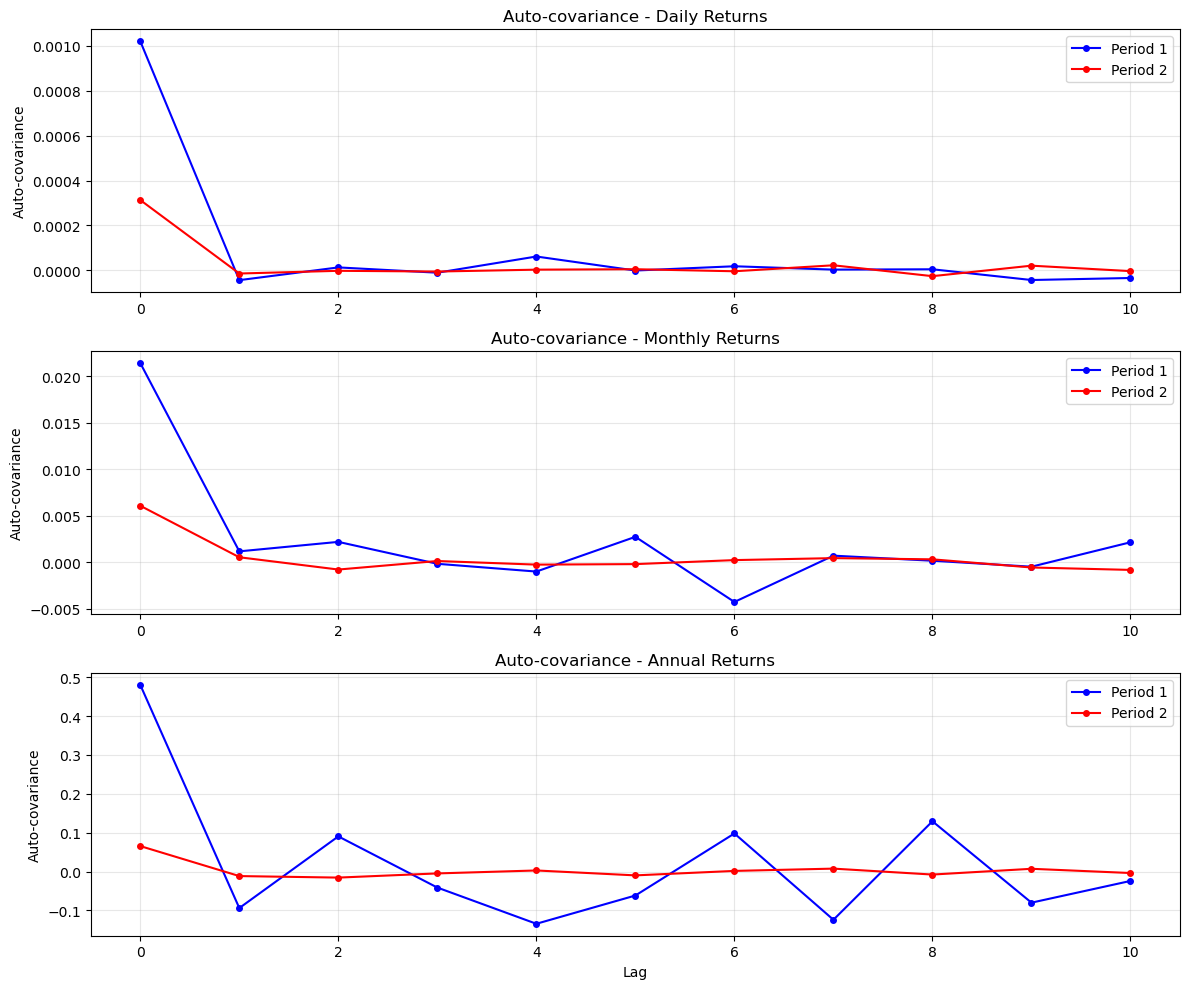

In [7]:
# Covariance fluctuation over time

print("\n" + "="*80)
print("AUTO-COVARIANCE TABLES - Stationarity Check")
print("="*80)

def generate_autocovariance_tables(returns, freq_name, n_lags=10):
    """Generates autocovariance tables for manual analysis"""
   
    # Split into two periods
    split_point = len(returns) // 2
    period1 = returns[:split_point]
    period2 = returns[split_point:]
   
    # Compute autocovariances
    autocov_period1 = acf(period1, nlags=n_lags, fft=False) * np.var(period1)
    autocov_period2 = acf(period2, nlags=n_lags, fft=False) * np.var(period2)
   
    # Comparison table
    comparison_table = pd.DataFrame({
        'Lag': range(n_lags + 1),
        f'AutoCov_P1_{freq_name}': autocov_period1,
        f'AutoCov_P2_{freq_name}': autocov_period2,
        f'Difference_{freq_name}': np.abs(autocov_period1 - autocov_period2)
    })
   
    return comparison_table, period1, period2

# Generate tables for the three frequencies
table_daily, p1_daily, p2_daily = generate_autocovariance_tables(rt_day, "Daily")
table_monthly, p1_monthly, p2_monthly = generate_autocovariance_tables(rt_month, "Monthly")
table_annual, p1_annual, p2_annual = generate_autocovariance_tables(rt_annual, "Annual")

# Display analyzed periods
print("\n--- ANALYZED PERIODS ---")
print(f"DAILY - Period 1: {p1_daily.index[0].date()} to {p1_daily.index[-1].date()}")
print(f"DAILY - Period 2: {p2_daily.index[0].date()} to {p2_daily.index[-1].date()}")
print(f"MONTHLY - Period 1: {p1_monthly.index[0].date()} to {p1_monthly.index[-1].date()}")
print(f"MONTHLY - Period 2: {p2_monthly.index[0].date()} to {p2_monthly.index[-1].date()}")
print(f"ANNUAL - Period 1: {p1_annual.index[0].date()} to {p1_annual.index[-1].date()}")
print(f"ANNUAL - Period 2: {p2_annual.index[0].date()} to {p2_annual.index[-1].date()}")

# Display tables
print("\n" + "="*80)
print("AUTO-COVARIANCE TABLE - DAILY RETURNS")
print("="*80)
print(table_daily.round(8))

print("\n" + "="*80)
print("AUTO-COVARIANCE TABLE - MONTHLY RETURNS")
print("="*80)
print(table_monthly.round(8))

print("\n" + "="*80)
print("AUTO-COVARIANCE TABLE - ANNUAL RETURNS")
print("="*80)
print(table_annual.round(8))

# Summary table of variances
print("\n" + "="*80)
print("SUMMARY OF VARIANCES BY PERIOD")
print("="*80)

# Autocovariance plots (optional - for visualization)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Daily
lags = range(len(table_daily))
axes[0].plot(lags, table_daily['AutoCov_P1_Daily'], 'bo-', label='Period 1', markersize=4)
axes[0].plot(lags, table_daily['AutoCov_P2_Daily'], 'ro-', label='Period 2', markersize=4)
axes[0].set_title('Auto-covariance - Daily Returns')
axes[0].set_ylabel('Auto-covariance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Monthly
lags = range(len(table_monthly))
axes[1].plot(lags, table_monthly['AutoCov_P1_Monthly'], 'bo-', label='Period 1', markersize=4)
axes[1].plot(lags, table_monthly['AutoCov_P2_Monthly'], 'ro-', label='Period 2', markersize=4)
axes[1].set_title('Auto-covariance - Monthly Returns')
axes[1].set_ylabel('Auto-covariance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Annual
lags = range(len(table_annual))
axes[2].plot(lags, table_annual['AutoCov_P1_Annual'], 'bo-', label='Period 1', markersize=4)
axes[2].plot(lags, table_annual['AutoCov_P2_Annual'], 'ro-', label='Period 2', markersize=4)
axes[2].set_title('Auto-covariance - Annual Returns')
axes[2].set_xlabel('Lag')
axes[2].set_ylabel('Auto-covariance')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [26]:
# FACT 2: Return are asymetric, Negative skewness

# According to the table of summary statistics, we already get the different values of the skewness:

print("The skewness is equal to:") 
print('Daily:', -3.606)
print('Weekly:', -1.936) 
print('Monthly:', -1.754) 
print('Annually:', -1.057)
print('We always get a negative skewness.','Also, sknewness is closer to 0 when the frequency lowers (when we take the annual sample).')


The skewness is equal to:
Daily: -3.606
Weekly: -1.936
Monthly: -1.754
Annually: -1.057
We always get a negative skewness. Also, sknewness is closer to 0 when the frequency lowers (when we take the annual sample).


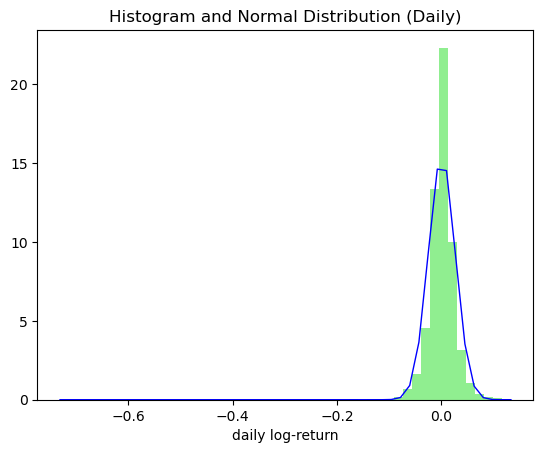


=> Apple’s datas are in adequation with this stylized fact


In [9]:
# We can also see it through the shape of the histogram, which is slightly skewed to the left, indicating a negative skewness:

plt.hist(rt_day, bins=50, density=True, color="lightgreen")
norm_y = stats.norm.pdf(np.linspace(rt_day.min(), rt_day.max()), loc=np.mean(rt_day), scale=np.std(rt_day))
plt.plot(np.linspace(rt_day.min(), rt_day.max()), norm_y, color="blue", linewidth=1)
plt.xlabel("daily log-return")
plt.title("Histogram and Normal Distribution (Daily)")
plt.show()

print('\n=> Apple’s datas are in adequation with this stylized fact')


In [27]:
# FACT 3: Kurtosis superior to 3

# According to the table of summary statistics, we get the different values of the kurtosis:

print('The kurtosis is equal to:', '\nDaily: ', 105.204, 
      '\nWeekly: ', 27.122, 
      '\nMonthly: ', 13.725, 
      '\nAnnually: ', 4.787)
print('\nWe can see that the kurtosis is always superior to 3.')

# With the shape of the histogram:
print('\nWe can also see it through the shape of the histogram, in FACT 3, which has a heavier tails than the normal distribution')

print('\n(Also, the excess kurtosis is also visible through QQ plot in FACT 5, because the the points near the center lie close to the diagonal, but they deviate at the tails: the left tail points fall below the diagonal, and the right tail points rise above it. This pattern indicates heavier tails than the normal distribution, suggesting that the distribution of returns exhibits excess kurtosis.)')
print('\n=> Apple’s datas are in adequation with this stylized fact')


The kurtosis is equal to: 
Daily:  105.204 
Weekly:  27.122 
Monthly:  13.725 
Annually:  4.787

We can see that the kurtosis is always superior to 3.

We can also see it through the shape of the histogram, in FACT 3, which has a heavier tails than the normal distribution

(Also, the excess kurtosis is also visible through QQ plot in FACT 5, because the the points near the center lie close to the diagonal, but they deviate at the tails: the left tail points fall below the diagonal, and the right tail points rise above it. This pattern indicates heavier tails than the normal distribution, suggesting that the distribution of returns exhibits excess kurtosis.)

=> Apple’s datas are in adequation with this stylized fact


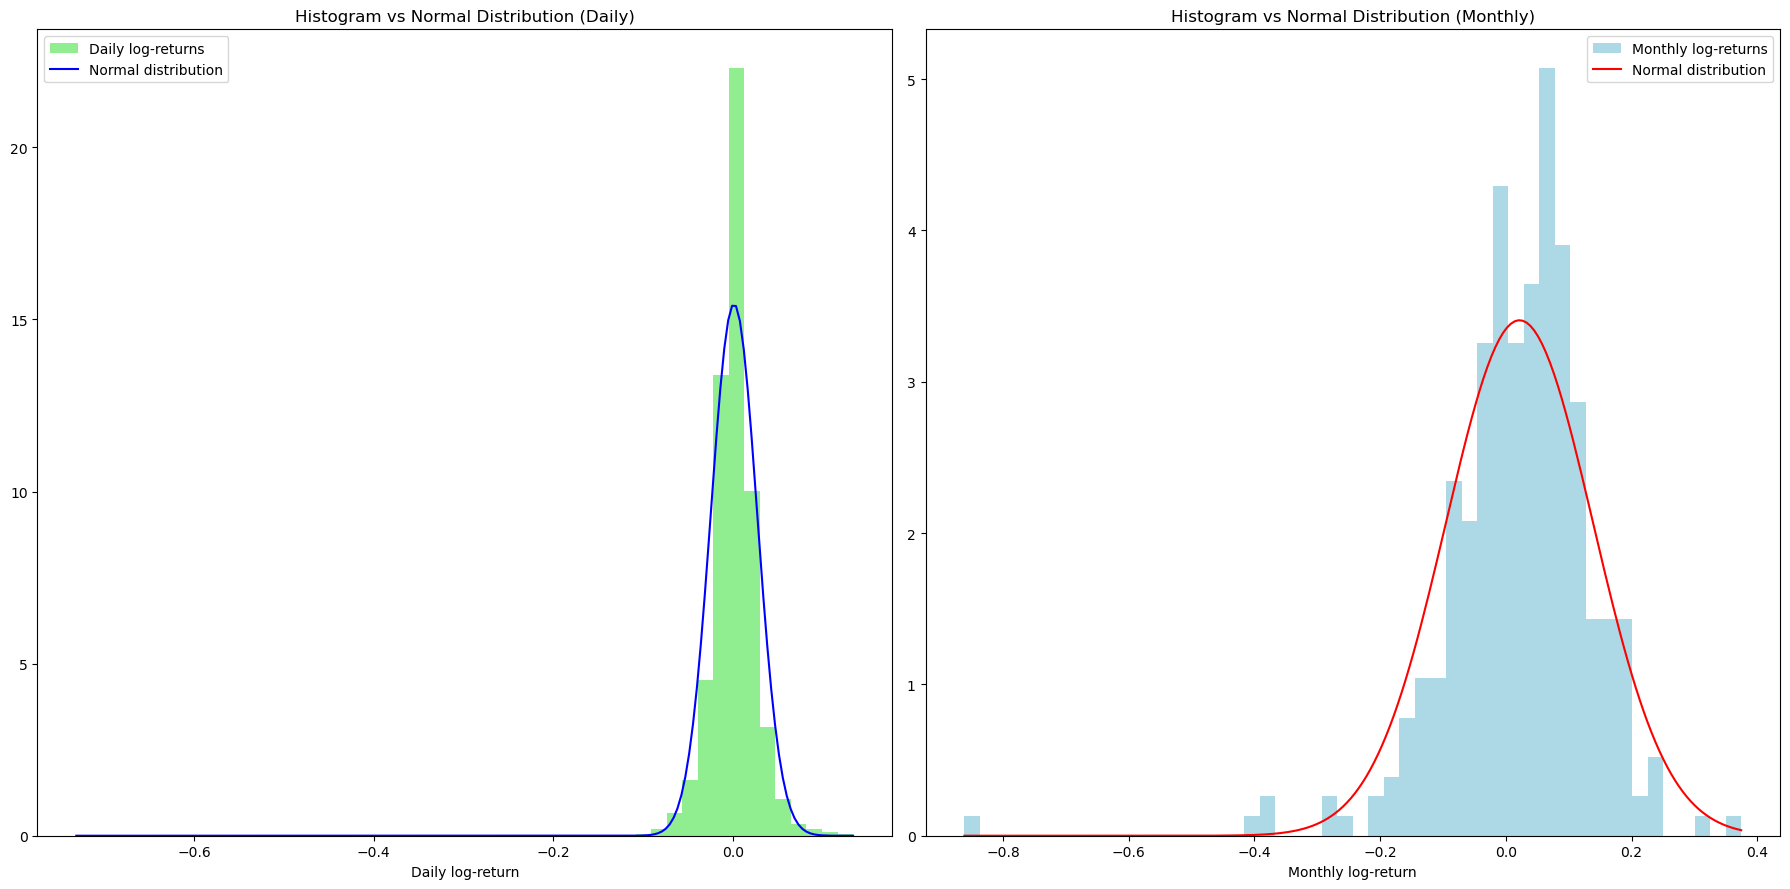

The histograms of daily and monthly log-returns exhibit a shape similar to that of a normal distribution.
We can also notice the heavier tails of the daily and monthly log-returns, compared to the normal distribution, which is in adequation with FACT 4. And also the negative skewness through the shape of the histograms (FACT 3).


In [28]:
# FACT 4: Aggregational gaussianity (return)

# Firstly, we can use the histograms method:

# Set up the subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# Histogram and Normal Distribution (Daily)
axs[0].hist(rt_day, bins=50, density=True, color="lightgreen", label="Daily log-returns")
x_day = np.linspace(rt_day.min(), rt_day.max(), 200)
norm_y_day = stats.norm.pdf(x_day, loc=np.mean(rt_day), scale=np.std(rt_day))
axs[0].plot(x_day, norm_y_day, color="blue", linewidth=1.5, label="Normal distribution")
axs[0].set_xlabel("Daily log-return")
axs[0].set_title("Histogram vs Normal Distribution (Daily)")
axs[0].legend()

# Histogram and Normal Distribution (Monthly)
axs[1].hist(rt_month, bins=50, density=True, color="lightblue", label="Monthly log-returns")
x_month = np.linspace(rt_month.min(), rt_month.max(), 200)
norm_y_month = stats.norm.pdf(x_month, loc=np.mean(rt_month), scale=np.std(rt_month))
axs[1].plot(x_month, norm_y_month, color="red", linewidth=1.5, label="Normal distribution")
axs[1].set_xlabel("Monthly log-return")
axs[1].set_title("Histogram vs Normal Distribution (Monthly)")
axs[1].legend()


plt.tight_layout()
plt.show()

print('The histograms of daily and monthly log-returns exhibit a shape similar to that of a normal distribution.'
     '\nWe can also notice the heavier tails of the daily and monthly log-returns, compared to the normal distribution, which is in adequation with FACT 4. And also the negative skewness through the shape of the histograms (FACT 3).')


In [12]:
# We can secondly realize some normality test:

# Test Jarque Bera with daily data:
JB_rt_day = jarque_bera(rt_day)
print('With daily data:', '\nJB p-value: ', round(JB_rt_day[1],3))

# Lilliefors test with daily data:
lill_rt_day = lilliefors(rt_day)
print('Lilliefors p-value:',round(lill_rt_day[1],3))

# Kolmogorov-Smirnov test with daily data:
ks_rt_day = kstest(rt_day, 'norm')
print('KS p-value:',round(ks_rt_day[1],3))

print('\nFor all 3 normality tests, the p-value is very low, so the result is statistically significant and the null hypothesis of normality is rejected. But when the fequency lowers (when we use annual data), the p-values increase and returns tend to be Gaussian.\n')

# Now we focus on p-value with annually data
print('With annually data: \nJB p-value:', jarque_bera(rt_annual)[1])
print('Lilliefors p-value:',lilliefors(rt_annual)[1])
print('KS p-value:', kstest(rt_annual, 'norm')[1])
print('\nWe can see we get higher p-value, and in the JB and Lilliefors test, the p-value is superior to 0.05, so we should not reject the null hypothesis of normality.')


With daily data: 
JB p-value:  0.0
Lilliefors p-value: 0.001
KS p-value: 0.0

For all 3 normality tests, the p-value is very low, so the result is statistically significant and the null hypothesis of normality is rejected. But when the fequency lowers (when we use annual data), the p-values increase and returns tend to be Gaussian.

With annually data: 
JB p-value: 0.05925494847659472
Lilliefors p-value: 0.19833307802430766
KS p-value: 0.009558957620124486

We can see we get higher p-value, and in the JB and Lilliefors test, the p-value is superior to 0.05, so we should not reject the null hypothesis of normality.


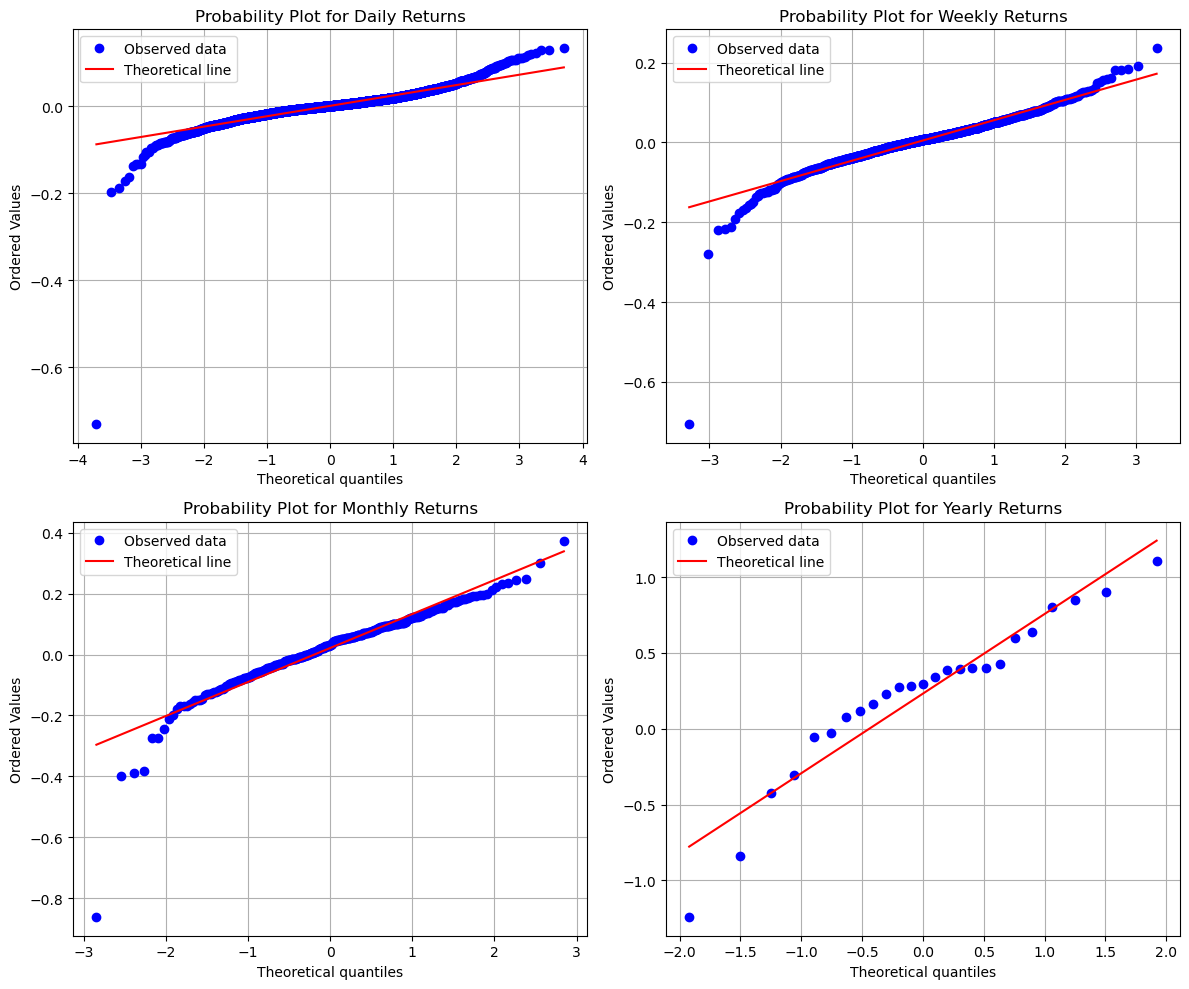

The blue points are closer to the red line for monthly and annual data, while they deviate more for daily and weekly data. This confirms the aggregational Gaussianity of returns. 

=> Apple’s datas are in adequation with this stylized fact


In [13]:
# Finally, let's use the QQ METHOD: 
# Set up the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Probability Plot for Daily Returns
stats.probplot(rt_day, dist="norm", plot=axs[0, 0])
axs[0, 0].set_title("Probability Plot for Daily Returns")
axs[0, 0].grid(True)
axs[0, 0].legend(["Observed data", "Theoretical line"], loc="best")

# Probability Plot for Weekly Returns
stats.probplot(rt_week, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Probability Plot for Weekly Returns")
axs[0, 1].grid(True)
axs[0, 1].legend(["Observed data", "Theoretical line"], loc="best")


# Probability Plot for Monthly Returns
stats.probplot(rt_month, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title("Probability Plot for Monthly Returns")
axs[1, 0].grid(True)
axs[1, 0].legend(["Observed data", "Theoretical line"], loc="best")


# Probability Plot for Yearly Returns
stats.probplot(rt_annual, dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("Probability Plot for Yearly Returns")
axs[1, 1].grid(True)
axs[1, 1].legend(["Observed data", "Theoretical line"], loc="best")


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

print('The blue points are closer to the red line for monthly and annual data, while they deviate more for daily and weekly data. This confirms the aggregational Gaussianity of returns. ')
print('\n=> Apple’s datas are in adequation with this stylized fact')


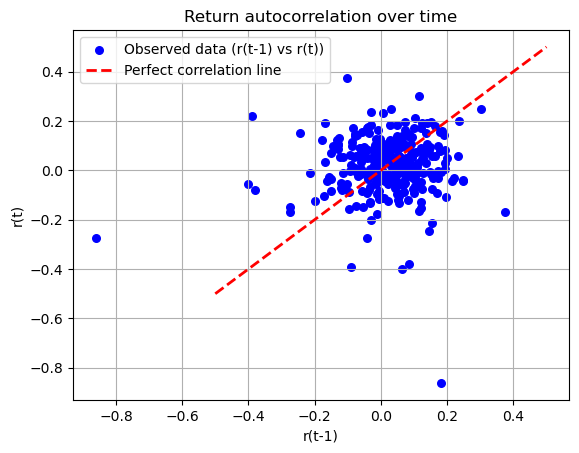

The blue points are not forming a straight line like the red one, so there is no correlation between r(t-1) and r(t). 
Returns are not autocorrelated

Empirically, with lag=1, the autocorrelation is also very close to 0: 
Autocorrelation =  0.064383


In [29]:
# FACT 5: Returns are not autocorrelated

# Firstly we can compare r(t-1) with r(t) visually:

def lag1_scatterplot(data, x_label, y_label, title):
    plt.scatter(data.shift(), data, color='blue', s=30, label='Observed data (r(t-1) vs r(t))')
    plt.plot([-0.5, 0.5], [-0.5, 0.5], linestyle='dashed', linewidth=2, color='red', label='Perfect correlation line')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
lag1_scatterplot(rt_month, 'r(t-1)', 'r(t)', 'Return autocorrelation over time')

print('The blue points are not forming a straight line like the red one, so there is no correlation between r(t-1) and r(t). \nReturns are not autocorrelated') 

# Secondly, we can calculate the empirical autocorrelation with lag=1:
autocorr = rt_month.shift().corr(rt_month, method='pearson')
print('\nEmpirically, with lag=1, the autocorrelation is also very close to 0: \nAutocorrelation = ', round(autocorr,7))


In [15]:
# Then, we can make some ACF test with different lags

# We create the dataframe with the p-value, through a function

def L(returns, nb_lag):
    my_LjungBox = sm.stats.diagnostic.acorr_ljungbox(returns, lags=nb_lag, boxpierce=True)
    Ljung_Box_pval=round(my_LjungBox['lb_pvalue'], 5)
    Box_Pierce_pval=round(my_LjungBox['bp_pvalue'], 5)
    lag=np.arange(1,nb_lag+1)
# We create the dataframe with the p-value 
    rt_day_ACF_pval=pd.DataFrame({'Lag':lag,'Ljung Box p-value':Ljung_Box_pval,'Box Pierce p-value':Box_Pierce_pval})
    print(rt_day_ACF_pval)

print('We use different lags depending on the period of the sample. \n\nWith daily data:')
print(L(rt_day,30), '\n\nWith weekly data:')
print(L(rt_week,15), '\n\nWith monthly data:')
print(L(rt_month,18), '\n\nWith annually data:')
L(rt_annual,4)

print('\nBased on the results, the daily returns show statistically significant but negligible autocorrelations, while for lower frequencies (weekly, monthly, annual), the autocorrelations are not significant (p-value > 0.05). Overall, we do not reject the null hypothesis that ACF = 0, indicating that returns are not autocorrelated.')


We use different lags depending on the period of the sample. 

With daily data:
    Lag  Ljung Box p-value  Box Pierce p-value
1     1            0.00037             0.00037
2     2            0.00147             0.00147
3     3            0.00281             0.00282
4     4            0.00001             0.00001
5     5            0.00002             0.00002
6     6            0.00004             0.00004
7     7            0.00004             0.00004
8     8            0.00004             0.00004
9     9            0.00004             0.00004
10   10            0.00001             0.00001
11   11            0.00002             0.00002
12   12            0.00000             0.00000
13   13            0.00000             0.00000
14   14            0.00000             0.00000
15   15            0.00000             0.00000
16   16            0.00000             0.00000
17   17            0.00000             0.00000
18   18            0.00000             0.00000
19   19            0.00000 

We start with a lags of 40 for daily log-returns, then we use a lags of 24 for weekly and monthly log-returns to capture potential medium-term autocorrelation patterns while avoiding excessive noise due to the smaller sample size.



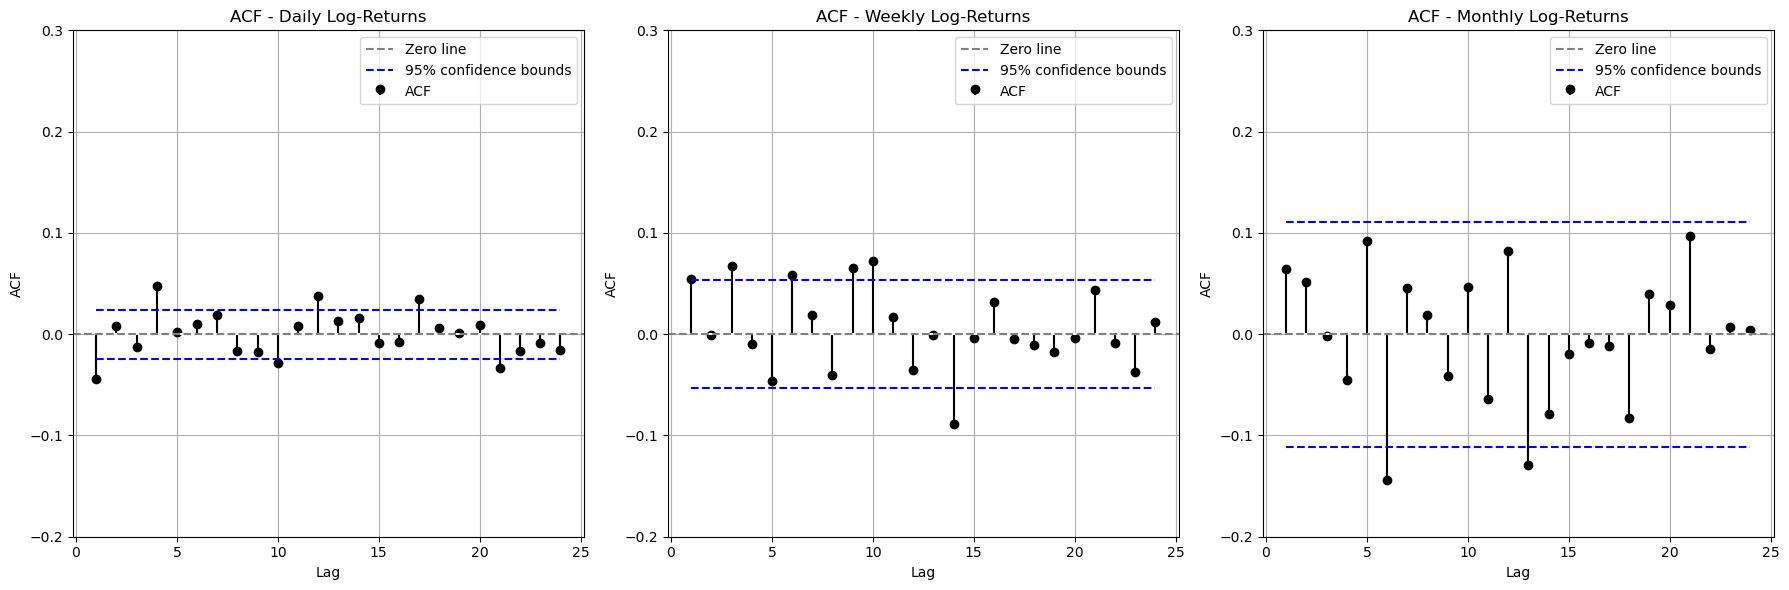

Using 40 lags, most of the autocorrelations remain within the confidence intervals, indicating that daily, weekly and monthly returns are mostly insignificant (i.e., not statistically different from 0 with high p-values) and therefore not autocorrelated.

=> Apple’s datas are in adequation with this stylized fact


In [16]:
# Finally, we can analyse the autocorrelation through confidence intervals:

print('We start with a lags of 40 for daily log-returns, then we use a lags of 24 for weekly and monthly log-returns to capture potential medium-term autocorrelation patterns while avoiding excessive noise due to the smaller sample size.\n')
lags = 40

# Set the layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# ACF of daily log-returns
lags = 24
acf_values_daily = acf(rt_day, nlags=lags)
confint = 1.96 / np.sqrt(len(rt_day))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)

axs[0].stem(np.arange(1, lags + 1), acf_values_daily[1:], linefmt='k-', markerfmt='ko', basefmt='w-', label='ACF')
axs[0].axhline(y=0, color='gray', linestyle='--', label='Zero line')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed', label='95% confidence bounds')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.2, 0.3)
axs[0].set_title('ACF - Daily Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)
axs[0].legend(loc='upper right')

# ACF of weekly log-returns
acf_values_weekly = acf(rt_week, nlags=lags)
confint_weekly = 1.96 / np.sqrt(len(rt_week))
confint_weekly_upper = np.full(lags, confint_weekly)
confint_weekly_lower = -np.full(lags, confint_weekly)

axs[1].stem(np.arange(1, lags + 1), acf_values_weekly[1:], linefmt='k-', markerfmt='ko', basefmt='w-', label='ACF')
axs[1].axhline(y=0, color='gray', linestyle='--', label='Zero line')
axs[1].plot(np.arange(1, lags + 1), confint_weekly_upper, color='blue', linestyle='dashed', label='95% confidence bounds')
axs[1].plot(np.arange(1, lags + 1), confint_weekly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.2, 0.3)
axs[1].set_title('ACF - Weekly Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].grid(True)
axs[1].legend(loc='upper right')

# ACF of monthly log-returns
lags=24
acf_values_monthly = acf(rt_month, nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(rt_month))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)

axs[2].stem(np.arange(1, lags + 1), acf_values_monthly[1:], linefmt='k-', markerfmt='ko', basefmt='w-', label='ACF')
axs[2].axhline(y=0, color='gray', linestyle='--', label='Zero line')
axs[2].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed', label='95% confidence bounds')
axs[2].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-0.2, 0.3)
axs[2].set_title('ACF - Monthly Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].grid(True)
axs[2].legend(loc='upper right')

# Set the space
plt.tight_layout()
plt.show()

print('Using 40 lags, most of the autocorrelations remain within the confidence intervals, indicating that daily, weekly and monthly returns are mostly insignificant (i.e., not statistically different from 0 with high p-values) and therefore not autocorrelated.\n' 
     '\n=> Apple’s datas are in adequation with this stylized fact')


In [30]:
# FACT 6:  volatility clustering
# We are looking at autocorrelation between absolute returns:

# Firstly, we can make some ACF test with different lags

print(L(abs(rt_day),25))
print('For lag going from 1 to 25, the p-value is always very low and inferior to 0.05, so we reject the null hypothesis (which was absolute returns not autocorrelated), so there is volatility clustering.')



    Lag  Ljung Box p-value  Box Pierce p-value
1     1                0.0                 0.0
2     2                0.0                 0.0
3     3                0.0                 0.0
4     4                0.0                 0.0
5     5                0.0                 0.0
6     6                0.0                 0.0
7     7                0.0                 0.0
8     8                0.0                 0.0
9     9                0.0                 0.0
10   10                0.0                 0.0
11   11                0.0                 0.0
12   12                0.0                 0.0
13   13                0.0                 0.0
14   14                0.0                 0.0
15   15                0.0                 0.0
16   16                0.0                 0.0
17   17                0.0                 0.0
18   18                0.0                 0.0
19   19                0.0                 0.0
20   20                0.0                 0.0
21   21      

For the same reason as for FACT 6, we start with a lags of 40 and then 24.



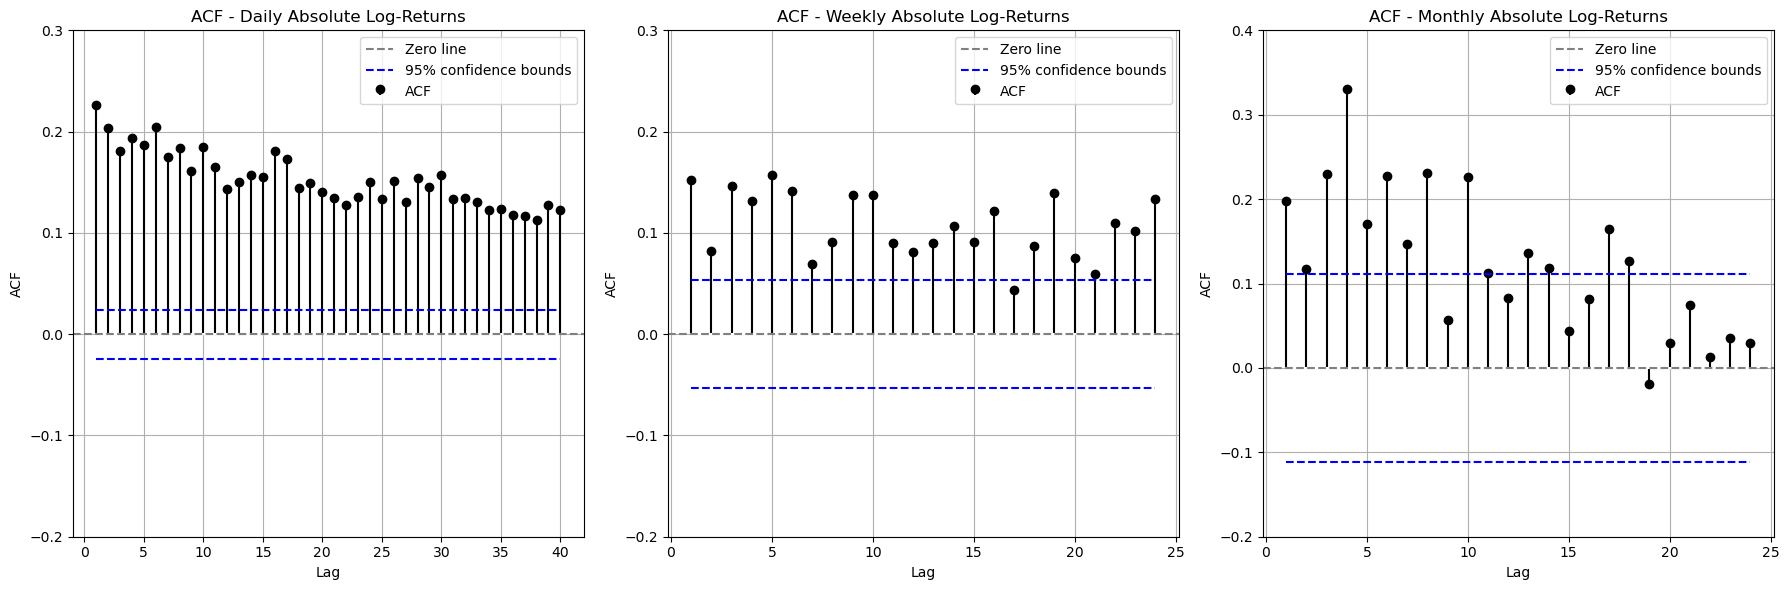

Most of the autocorrelations lie outside the confidence intervals, indicating that daily, weekly and monthly returns are mostly significant (i.e. statistically different from 0 with low p-values) and therefore autocorrelated.
ACF are also mostly strictly positive.

=> Apple’s datas are in adequation with this stylized fact


In [18]:
# Secondly, we can analyse the autocorrelation through confidence intervals:

print('For the same reason as for FACT 6, we start with a lags of 40 and then 24.\n')

lags = 40

# Set the layout 
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# ACF of daily absolute log-returns
acf_values_daily2 = acf(abs(rt_day), nlags=lags)
confint = 1.96 / np.sqrt(len(rt_day))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)

axs[0].stem(np.arange(1, lags + 1), acf_values_daily2[1:], linefmt='k-', markerfmt='ko', basefmt='w-', label='ACF')
axs[0].axhline(y=0, color='gray', linestyle='--', label='Zero line')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed', label='95% confidence bounds')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.2, 0.3)
axs[0].set_title('ACF - Daily Absolute Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)
axs[0].legend(loc='upper right')

# ACF of weekly absolute log-returns 
lags = 24
acf_values_weekly2 = acf(abs(rt_week), nlags=lags)
confint_weekly = 1.96 / np.sqrt(len(rt_week))
confint_weekly_upper = np.full(lags, confint_weekly)
confint_weekly_lower = -np.full(lags, confint_weekly)

axs[1].stem(np.arange(1, lags + 1), acf_values_weekly2[1:], linefmt='k-', markerfmt='ko', basefmt='w-', label='ACF')
axs[1].axhline(y=0, color='gray', linestyle='--', label='Zero line')
axs[1].plot(np.arange(1, lags + 1), confint_weekly_upper, color='blue', linestyle='dashed', label='95% confidence bounds')
axs[1].plot(np.arange(1, lags + 1), confint_weekly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.2, 0.3)
axs[1].set_title('ACF - Weekly Absolute Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].grid(True)
axs[1].legend(loc='upper right')

# ACF of monthly absolute log-returns 
acf_values_monthly2 = acf(abs(rt_month), nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(rt_month))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)

axs[2].stem(np.arange(1, lags + 1), acf_values_monthly2[1:], linefmt='k-', markerfmt='ko', basefmt='w-', label='ACF')
axs[2].axhline(y=0, color='gray', linestyle='--', label='Zero line')
axs[2].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed', label='95% confidence bounds')
axs[2].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-0.2, 0.4)
axs[2].set_title('ACF - Monthly Absolute Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].grid(True)
axs[2].legend(loc='upper right')

# Layout
plt.tight_layout()
plt.show()


print('Most of the autocorrelations lie outside the confidence intervals, indicating that daily, weekly and monthly returns are mostly significant (i.e. statistically different from 0 with low p-values) and therefore autocorrelated.\n'
      'ACF are also mostly strictly positive.'
     '\n\n=> Apple’s datas are in adequation with this stylized fact')


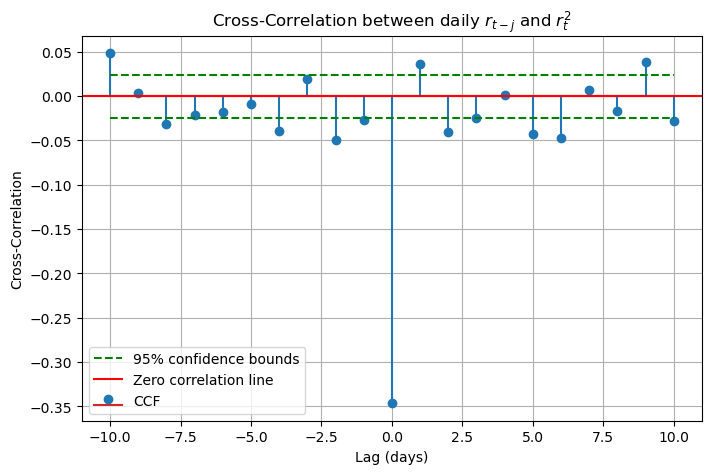

The cross-correlation between daily returns and squared returns shows mostly negative values at short lags, indicating that volatility tends to increase after price declines, consistent with the leverage effect.

=> Apple's datas are in adequation with this stylized fact.


In [31]:
# FACT 7: Leverage effect

# Graph:
# Define a function
def ccf(x, y, lag_max = 100):
    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

# Choose the max lag and execute the function
lag_max = 10
cross_corr = ccf(rt_day,rt_day**2,lag_max=lag_max)

# Plot results
lags = np.arange(-lag_max, lag_max + 1)

# ACF of daily log-returns with confidence intervals:
confint_daily = 1.96 / np.sqrt(len(rt_day))
confint_daily_upper = np.full(len(lags), confint_daily)
confint_daily_lower = -np.full(len(lags), confint_daily)

plt.figure(figsize=(8, 5))
plt.stem(lags, cross_corr, label='CCF')
plt.plot(lags, confint_daily_upper, color='green', linestyle='dashed', label='95% confidence bounds')
plt.plot(lags, confint_daily_lower, color='green', linestyle='dashed')
plt.axhline(y=0, color='red', linestyle='-', label='Zero correlation line')
plt.xlabel('Lag (days)')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between daily $r_{t-j}$ and $r_t^2$')
plt.grid(True)
plt.legend(loc='best')
plt.show()

print('The cross-correlation between daily returns and squared returns shows mostly negative values at short lags, indicating that volatility tends to increase after price declines, consistent with the leverage effect.\n')
print("=> Apple's datas are in adequation with this stylized fact.")


In [20]:
# PART 2: Now, let's make a CAPM regression and a 

# I didn't manage to upload the document via CSV, so I found another way to upload it.
import requests, zipfile, io

url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    file_name = z.namelist()[0]
    with z.open(file_name) as f:
        df = pd.read_csv(f, skiprows=3)

# I readjusted the dataframe and its index:
df = df.rename(columns={df.columns[0]: "Date"})
df = df.set_index(df.columns[0])

df=df.head(1182) # I took the monthly value, after the 1182th line it is the annual value
df.index = pd.to_datetime(df.index, format="%Y%m")

print(df)
print(type(df.index))

             Mkt-RF      SMB      HML       RF
Date                                          
1926-07-01     2.89    -2.55    -2.39     0.22
1926-08-01     2.64    -1.14     3.81     0.25
1926-09-01     0.38    -1.36     0.05     0.23
1926-10-01    -3.27    -0.14     0.82     0.32
1926-11-01     2.54    -0.11    -0.61     0.31
...             ...      ...      ...      ...
2024-08-01     1.60    -3.49    -1.10     0.48
2024-09-01     1.72    -0.13    -2.77     0.40
2024-10-01    -1.00    -0.99     0.86     0.39
2024-11-01     6.49     4.46     0.15     0.40
2024-12-01    -3.17    -2.71    -3.00     0.37

[1182 rows x 4 columns]
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [21]:
# Not exactly the same date but it is the same month
df_adj = df['1999-02':'2024-12']

# Now I added the monthly log excess return of Apple:
df_adj['Apple excess ret.']=rt_month.values - pd.to_numeric(df_adj['RF'], errors='coerce')  # because some of the values are not numerical

df_adj=df_adj.rename(columns={df_adj.columns[0]: 'CRSP_VW'})
df_adj


/var/folders/bl/x60glkc16f32tjg5b39jnkr40000gn/T/ipykernel_5216/3211946770.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adj['Apple excess ret.']=rt_month.values - pd.to_numeric(df_adj['RF'], errors='coerce')  # because some of the values are not numerical


,CRSP_VW,SMB,HML,RF,Apple excess ret.
Date,,,,,
1999-02-01,-4.08,-6.02,1.95,0.35,-0.518159
1999-03-01,3.48,-3.84,-2.61,0.43,-0.398194
1999-04-01,4.34,3.89,2.40,0.37,-0.123142
1999-05-01,-2.46,3.32,2.49,0.34,-0.383032
1999-06-01,4.77,3.23,-3.22,0.40,-0.350198
...,...,...,...,...,...
2024-08-01,1.60,-3.49,-1.10,0.48,-0.448159
2024-09-01,1.72,-0.13,-2.77,0.40,-0.382684
2024-10-01,-1.00,-0.99,0.86,0.39,-0.420902


In [22]:
# CAPM regression
import statsmodels.api as sm

y = df_adj.iloc[:,4]
x1 = pd.to_numeric(df_adj.iloc[:,0], errors='coerce') # Some of the value are not all numerical

X = sm.add_constant(x1)
reg1 = sm.OLS(y, X).fit()
reg1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Apple excess ret.   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     48.18
Date:                Wed, 28 Jan 2026   Prob (F-statistic):           2.29e-11
Time:                        15:37:43   Log-Likelihood:                 70.531
No. Observations:                 311   AIC:                            -137.1
Df Residuals:                     309   BIC:                            -129.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1444      0.011    -13.043      0.000      -0.166      -0.123
CRSP_VW        0.0167      0.002      6.941      0.000       0.012       0.021
==============================================================================
Omnibus:                       88.489   Durbin-Watson:                   0.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.020
Skew:                          -1.320   Prob(JB):                     5.61e-52
Kurtosis:                       6.354   Cond. No.                         4.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

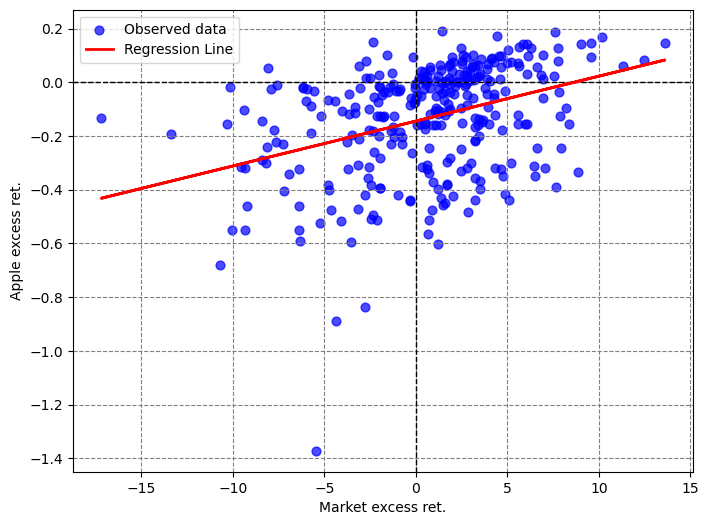

In [23]:
# Represent the predicted values through an histogram
plt.figure(figsize=(8, 6))
plt.scatter(x1, y, color="blue", s=40, alpha=0.7, label='Observed data')
plt.xlabel("Market excess ret.")
plt.ylabel("Apple excess ret.")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.grid(linestyle="--", color="grey")

# Compute the predicted values
y_pred = reg1.predict(X)

# Draw the regression line in red
plt.plot(x1, y_pred, color="red", linewidth=2, label="Regression Line")

plt.legend()
plt.show()

In [24]:
# Regression for the FAMA FRENCH model 
y = df_adj['Apple excess ret.']   
x1 = df_adj[['CRSP_VW', 'SMB', 'HML']] 
x1 = x1.apply(pd.to_numeric, errors='coerce')

X = sm.add_constant(x1)
reg1 = sm.OLS(y, X).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Apple excess ret.   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     20.21
Date:                Wed, 28 Jan 2026   Prob (F-statistic):           5.60e-12
Time:                        15:37:44   Log-Likelihood:                 76.022
No. Observations:                 311   AIC:                            -144.0
Df Residuals:                     307   BIC:                            -129.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1433      0.011    -13.117      0.000      -0.165      -0.122
CRSP_VW        0.0159      0.002      6.468      0.000       0.011       0.021
SMB            0.0026      0.003      0.749      0.455      -0.004       0.009
HML           -0.0098      0.003     -3.094      0.002      -0.016      -0.004
==============================================================================
Omnibus:                       72.645   Durbin-Watson:                   0.526
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.857
Skew:                          -1.179   Prob(JB):                     3.89e-34
Kurtosis:                       5.513   Cond. No.                         4.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""